# Langfuse Evaluation을 사용한 RAG 답변 평가

---


## 환경 설정 및 준비


`(1) Env 환경변수`


In [1]:
from dotenv import load_dotenv

load_dotenv()

True

`(2) 기본 라이브러리`


In [2]:
import os
from glob import glob

from pprint import pprint
import json

import uuid

import pandas as pd
import numpy as np

import warnings

warnings.filterwarnings("ignore")

`(3) Test Data`


In [3]:
# Test 데이터셋에 대한 QA 생성 결과를 리뷰한 후 다시 로드
import pandas as pd

df_qa_test = pd.read_excel("../data/testset.xlsx")

print(f"테스트셋: {df_qa_test.shape[0]}개 문서")
df_qa_test.head(2)

테스트셋: 49개 문서


user_input  \
0  Tesla, Inc.는 미국에서 어떤 역할을 하고 있으며, 이 회사의 주요 제품과 ...   
1                    Forbes Global 2000에서 테슬라 순위 뭐야?   

                                  reference_contexts  \
0  ['Tesla, Inc.는 미국의 다국적 자동차 및 청정 에너지 회사입니다. 이 회...   
1  ['Tesla의 차량 생산은 2008년 Roadster로 시작하여 Model S (...   

                                           reference  \
0  Tesla, Inc.는 미국의 다국적 자동차 및 청정 에너지 회사로, 전기 자동차(...   
1            테슬라는 Forbes Global 2000에서 69위에 랭크되었습니다.   

                       synthesizer_name  
0  single_hop_specifc_query_synthesizer  
1  single_hop_specifc_query_synthesizer

In [5]:
# Evaluaiton 데이터셋에 RAGAS 평가 결과를 로드

ragas_evaluation = pd.read_csv("../data/evaluation_result.csv")
ragas_evaluation.head(2)

user_input  \
0  Tesla, Inc.는 미국에서 어떤 역할을 하고 있으며, 이 회사의 주요 제품과 ...   
1                    Forbes Global 2000에서 테슬라 순위 뭐야?   

                                  retrieved_contexts  \
0  ['Tesla, Inc.는 미국의 다국적 자동차 및 청정 에너지 회사입니다. 이 회...   
1  ['Tesla의 차량 생산은 2008년 Roadster로 시작하여 Model S (...   

                                            response  \
0  Tesla, Inc.는 미국의 다국적 자동차 및 청정 에너지 회사로서, 전기 자동차...   
1            Forbes Global 2000에서 테슬라는 69위에 랭크되었습니다.   

                                           reference  context_recall  \
0  Tesla, Inc.는 미국의 다국적 자동차 및 청정 에너지 회사로, 전기 자동차(...             1.0   
1            테슬라는 Forbes Global 2000에서 69위에 랭크되었습니다.             1.0   

   faithfulness  factual_correctness(mode=f1)  
0           1.0                           1.0  
1           1.0                           1.0

---

## **평가 지표** (Evaluation Metric)

#### 1) **검색(Retrieval) 평가**

- **Non-Rank Based Metrics**: Accuracy, Precision, Recall@k 등을 통해 관련성의 이진적 평가를 수행

- **Rank-Based Metrics**: MRR(Mean Reciprocal Rank), MAP(Mean Average Precision)를 통해 검색 결과의 순위를 고려한 평가를 수행

- **RAG 특화 지표**: 기존 검색 평가 방식의 한계를 보완하는 LLM-as-judge 방식 도입

- **포괄적 평가**: 정확도, 관련성, 다양성, 강건성을 통합적으로 측정

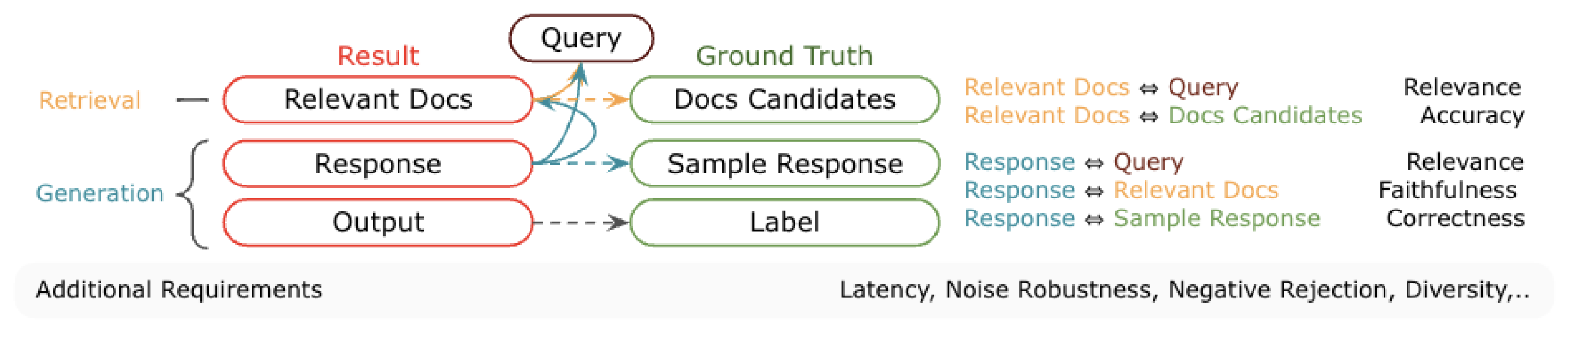

#### 2) **생성(Generation) 평가**

- **전통적 평가**: ROUGE(요약), BLEU(번역), BertScore(의미 유사도) 지표 활용

- **LLM 기반 평가**: 응집성, 관련성, 유창성을 종합적으로 판단하는 새로운 접근법 도입 (전통적인 참조 비교가 어려운 상황에서 유용)

- **다차원 평가**: 품질, 일관성, 사실성, 가독성, 사용자 만족도를 포괄적 측정

- **상세 프롬프트**와 **사용자 선호도** 기준으로 생성 텍스트 품질 평가

[출처] https://arxiv.org/abs/2405.07437


---

## **검색 도구 정의**


### 1) **벡터스토어** 로드

- **Chroma DB** 설정에서 모델, 컬렉션명, 저장 경로 지정


In [6]:
# 벡터 저장소 로드
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

chroma_db = Chroma(
    collection_name="db_korean_cosine_metadata",
    embedding_function=embeddings,
    persist_directory="../chroma_db",
)

### 2) **Retriever** 변환

- **Chroma DB** 를 사용하여 벡터스토어에서 검색 기능을 구현


In [7]:
# 벡터저장소 검색기 생성
chroma_k = chroma_db.as_retriever(
    search_kwargs={"k": 4},
)

# 벡터저장소 검색기를 사용하여 검색
query = "테슬라의 회장은 누구인가요?"

retrieved_docs = chroma_k.invoke(query)

# 검색 결과 출력
for doc in retrieved_docs:
    print(f"- {doc.page_content} [출처: {doc.metadata['source']}]")
    print("-" * 200)
    print()

- <Document>
### Roadster (2005–2009)

Elon Musk는 주류 차량으로 확장하기 전에 프리미엄 스포츠카로 시작하는 전략에 초점을 맞춰 적극적인 역할을 수행했습니다. 후속 자금 조달에는 Valor Equity Partners (2006)와 Sergey Brin, Larry Page, Jeff Skoll과 같은 기업가의 투자가 포함되었습니다.

2007년 8월, Eberhard는 CEO에서 물러나라는 요청을 받았고, Tarpenning은 2008년 1월에 이어졌습니다. Michael Marks는 Ze'ev Drori가 인수하기 전에 임시 CEO를 역임했으며, Musk는 2008년 10월에 인수했습니다. Eberhard는 2009년 6월 Musk를 상대로 소송을 제기했지만 나중에 기각되었습니다.
</Document>
<Source>이 문서는 미국 전기차 회사인 '테슬라'에 대한 문서입니다.</Source> [출처: ../data\테슬라_KR.md]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

- <Document>
Tesla, Inc.는 미국의 다국적 자동차 및 청정 에너지 회사입니다. 이 회사는 전기 자동차(BEV), 고정형 배터리 에너지 저장 장치, 태양 전지판, 태양광 지붕널 및 관련 제품/서비스를 설계, 제조 및 판매합니다. 2003년 7월 Martin Eberhard와 Marc Tarpenning이 Tesla Motors로 설립했으며, Nikola Tesla를 기리기 위해 명명되었습니다. Elon Musk는 2004년 Tesla의 초기 자금 조달을 주도하여 2008년에 회장 겸 CEO가 되었습니다.
</Docume

## **RAG Chain** 정의

- OpenAI gpt-4.1-mini 모델 활용


In [8]:
# 각 쿼리에 대한 검색 결과를 한꺼번에 Context로 전달해서 답변을 생성
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate


def create_rag_chain(retriever, llm):

    template = """Answer the following question based on this context. If the context is not relevant to the question, just answer with '답변에 필요한 근거를 찾지 못했습니다.'

    [Context]
    {context}

    [Question]
    {question}

    [Answer]
    """

    prompt = ChatPromptTemplate.from_template(template)

    def format_docs(docs):
        return "\n\n".join([f"{doc.page_content}" for doc in docs])

    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )

    return rag_chain

In [9]:
# RAG 체인 생성 및 테스트
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0.5)

openai_rag_chain = create_rag_chain(chroma_k, llm)

question = "테슬라의 회장은 누구인가요?"
answer = openai_rag_chain.invoke(question)

print(f"쿼리: {question}")
print(f"답변: {answer}")

쿼리: 테슬라의 회장은 누구인가요?
답변: Elon Musk입니다.


---

## **Langfuse를 활용한 평가**

1. **환경 설정**: Langfuse 클라이언트 초기화 및 인증
2. **데이터셋 업로드**: `create_dataset()` 및 `create_dataset_item()` 사용
3. **모니터링 RAG 체인**: `CallbackHandler`로 자동 추적 설정
4. **평가 실행**: 데이터셋 기반 체계적 평가

**주요 장점:**

- 🔄 자동화된 추적 및 로깅
- 📊 시각적 대시보드 제공
- 🔍 다양한 평가 지표 지원
- 🚀 확장 가능한 평가 파이프라인


---

### 1) **Langfuse 환경 설정**


In [10]:
from langfuse.langchain import CallbackHandler

# Langfuse 콜백 핸들러 생성
langfuse_handler = CallbackHandler()

In [11]:
from langfuse import get_client

# Langfuse 클라이언트 초기화
langfuse_client = get_client()

# 인증 확인
print("Langfuse 인증 상태:", langfuse_client.auth_check())

Langfuse 인증 상태: True


---

### 2) **평가용 데이터셋 업로드**


In [12]:
df_qa_test.head(2)

user_input  \
0  Tesla, Inc.는 미국에서 어떤 역할을 하고 있으며, 이 회사의 주요 제품과 ...   
1                    Forbes Global 2000에서 테슬라 순위 뭐야?   

                                  reference_contexts  \
0  ['Tesla, Inc.는 미국의 다국적 자동차 및 청정 에너지 회사입니다. 이 회...   
1  ['Tesla의 차량 생산은 2008년 Roadster로 시작하여 Model S (...   

                                           reference  \
0  Tesla, Inc.는 미국의 다국적 자동차 및 청정 에너지 회사로, 전기 자동차(...   
1            테슬라는 Forbes Global 2000에서 69위에 랭크되었습니다.   

                       synthesizer_name  
0  single_hop_specifc_query_synthesizer  
1  single_hop_specifc_query_synthesizer

In [13]:
from typing import List, Dict



# 평가 데이터셋 생성 및 업로드


def create_evaluation_dataset(name: str, data: List[Dict]):

    """평가용 데이터셋 생성"""


    # Langfuse에서 데이터셋 생성

    dataset = langfuse_client.create_dataset(name=name)


    # 데이터셋 아이템 추가

    for item in data:

        langfuse_client.create_dataset_item(
            dataset_name=name,

            input=item.get("user_input", ""),
            expected_output=item.get("reference", ""),
            metadata={
                "reference_contexts": item.get("reference_contexts", ""),
            },
        )

    return dataset



# 평가용 데이터셋 생성



evaluation_dataset = create_evaluation_dataset(

    name="RAG_Evaluation_Dataset",
    data=[
        {

            "user_input": row["user_input"],
            "reference": row["reference"],
            "reference_contexts": row["reference_contexts"],
        }
        for _, row in df_qa_test.iterrows()
    ],
)



print(f"생성된 데이터셋: {evaluation_dataset.name}")

생성된 데이터셋: RAG_Evaluation_Dataset


In [14]:
# 생성된 데이터셋 확인
dataset = langfuse_client.get_dataset(name="RAG_Evaluation_Dataset")
print(f"생성된 데이터셋: {dataset.name}")

생성된 데이터셋: RAG_Evaluation_Dataset


In [15]:
# 데이터셋 아이템 확인
dataset_items = dataset.items
print(f"데이터셋 크기: {len(dataset_items)}")

# 평가용 데이터셋 아이템 출력
for item in dataset_items:
    print(f"입력: {item.input}")
    print(f"기대 출력: {item.expected_output}")
    print(f"메타데이터: {item.metadata}")
    print("-" * 150)

데이터셋 크기: 49
입력: Elon Musk의 560억 달러 급여 패키지가 델라웨어 법원에서 거부된 이유와 그의 Tesla에서의 초기 전략적 역할은 무엇인가요?
기대 출력: Elon Musk의 560억 달러 급여 패키지는 2024년 12월 델라웨어 법원에서 부적절한 이사회 승인으로 인해 거부되었습니다. Tesla에서의 초기 전략적 역할로는 주류 차량으로 확장하기 전에 프리미엄 스포츠카로 시작하는 전략에 초점을 맞추는 것이었습니다. 그는 Valor Equity Partners와 같은 투자자들로부터 자금을 조달하며 Tesla의 성장을 이끌었습니다.
메타데이터: {'reference_contexts': '[\'<1-hop>\\n\\n2024년 12월, 델라웨어 법원은 부적절한 이사회 승인을 이유로 Elon Musk의 560억 달러 급여 패키지를 거부했습니다.\\n\\n## 자동차 제품 및 서비스\\n\\n2024년 11월 현재 Tesla는 Model S, Model X, Model 3, Model Y, Semi 및 Cybertruck의 6가지 차량 모델을 제공합니다. 다음은 Tesla 모델 목록입니다.\', "<2-hop>\\n\\nElon Musk는 주류 차량으로 확장하기 전에 프리미엄 스포츠카로 시작하는 전략에 초점을 맞춰 적극적인 역할을 수행했습니다. 후속 자금 조달에는 Valor Equity Partners (2006)와 Sergey Brin, Larry Page, Jeff Skoll과 같은 기업가의 투자가 포함되었습니다.\\n\\n2007년 8월, Eberhard는 CEO에서 물러나라는 요청을 받았고, Tarpenning은 2008년 1월에 이어졌습니다. Michael Marks는 Ze\'ev Drori가 인수하기 전에 임시 CEO를 역임했으며, Musk는 2008년 10월에 인수했습니다. Eberhard는 2009년 6월 Musk를 상대로 소송을 제기했지만 나중에 기각되었습니다."]'}
-------------------------------------

---

### 3) **체인 성능 모니터링**


In [16]:
def create_monitored_rag_chain(retriever, llm):
    """Langfuse 콜백이 포함된 모니터링 RAG 체인"""

    # 기본 RAG 체인 생성
    chain = create_rag_chain(retriever, llm)

    # 추적 가능한 실행 함수
    def invoke_with_tracing(question: str, **kwargs):
        """추적이 포함된 체인 실행"""
        return chain.invoke(
            question,
            config={
                "callbacks": [langfuse_handler],
                "metadata": {
                    "langfuse_tags": ["evaluation", "rag"],  # Langfuse 태그 설정
                    "evaluation_run": True,  # 메타데이터 속성 추가
                },
            },
            **kwargs,
        )

    return invoke_with_tracing


# 모니터링 RAG 체인 생성
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0.1)
openai_rag_chain = create_monitored_rag_chain(chroma_k, llm)

# 체인 실행
question = "테슬라의 회장은 누구인가요?"
answer = openai_rag_chain(question)
print(f"쿼리: {question}")
print(f"답변: {answer}")

쿼리: 테슬라의 회장은 누구인가요?
답변: Elon Musk입니다.


---

### 4) **데이터셋 기반 평가 실행**


In [17]:
from langchain.evaluation import load_evaluator
from korouge_score import rouge_scorer
from krag.tokenizers import KiwiTokenizer


# 평가기 설정
class CustomKiwiTokenizer(KiwiTokenizer):
    def tokenize(self, text):
        try:
            return [t.form for t in super().tokenize(text)]
        except Exception as e:
            return text.split()


tokenizer = CustomKiwiTokenizer(model_type="knlm", typos="basic")

rouge_scorer = rouge_scorer.RougeScorer(
    ["rouge1", "rouge2", "rougeL"], tokenizer=tokenizer
)

correctness_evaluator = load_evaluator(
    evaluator="labeled_criteria", criteria="correctness", llm=llm
)

In [18]:
from dataclasses import dataclass
from typing import Any, Dict, List, Optional
from langfuse.langchain import CallbackHandler
from langfuse import get_client


@dataclass
class EvaluationResult:
    """평가 결과를 담는 데이터 클래스"""

    item_id: str
    input: Any
    output: str
    expected_output: str
    scores: Dict[str, float]
    details: Dict[str, Any]
    trace_id: Optional[str] = None
    error: Optional[str] = None


def run_dataset_evaluation(
    dataset_name: str, rag_chain, run_name: str
) -> List[EvaluationResult]:
    """데이터셋 전체에 대한 평가 실행"""

    # 데이터셋 가져오기
    langfuse_client = get_client()
    dataset = langfuse_client.get_dataset(name=dataset_name)
    if not dataset:
        raise ValueError(f"데이터셋 '{dataset_name}'이(가) 존재하지 않습니다.")

    print(f"📊 RAG 평가 시작: {dataset_name} ({len(dataset.items)}개 항목)")

    results = []
    successful = 0
    failed = 0

    for idx, item in enumerate(dataset.items, 1):
        try:
            print(f"\n🔄 아이템 {idx}/{len(dataset.items)} 처리 중...")

            # Langfuse 트레이싱 설정
            with item.run(run_name=run_name) as root_span:
                langfuse_handler = CallbackHandler()

                # RAG 체인 실행
                if hasattr(rag_chain, "invoke"):
                    output = rag_chain.invoke(
                        item.input,
                        config={
                            "callbacks": [langfuse_handler],
                            "metadata": {
                                "langfuse_tags": ["evaluation", "rag"],
                                "evaluation_run": True,
                            },
                        },
                    )
                else:
                    output = rag_chain(item.input)

                # 평가 수행
                scores, details = {}, {}

                # 1. ROUGE 점수 평가
                try:
                    rouge_results = rouge_scorer.score(
                        str(item.expected_output), str(output)
                    )
                    rouge_scores = {
                        "rouge1": rouge_results["rouge1"].fmeasure,
                        "rouge2": rouge_results["rouge2"].fmeasure,
                        "rougeL": rouge_results["rougeL"].fmeasure,
                    }
                    scores["rouge"] = sum(rouge_scores.values()) / len(rouge_scores)
                    details["rouge"] = rouge_scores
                except Exception as e:
                    scores["rouge"] = 0.0
                    details["rouge"] = {"error": str(e)}

                # 2. 정확성 평가
                try:
                    correct_result = correctness_evaluator.evaluate_strings(
                        input=str(item.input),
                        prediction=str(output),
                        reference=str(item.expected_output),
                    )
                    scores["correctness"] = float(correct_result.get("score", 0))
                    details["correctness"] = {
                        "reasoning": correct_result.get("reasoning", ""),
                        "score": correct_result.get("score", 0),
                    }
                except Exception as e:
                    scores["correctness"] = 0.0
                    details["correctness"] = {"error": str(e)}

                # 전체 점수 계산 및 기록
                overall_score = sum(scores.values()) / len(scores)
                root_span.score(name="overall", value=overall_score)

                # 각 평가 점수 기록
                for score_name, score_value in scores.items():
                    root_span.score(name=score_name, value=score_value)

                # 결과 저장
                result = EvaluationResult(
                    item_id=item.id,
                    input=item.input,
                    output=str(output),
                    expected_output=(
                        str(item.expected_output) if item.expected_output else ""
                    ),
                    scores=scores,
                    details=details,
                    trace_id=getattr(root_span, "trace_id", None),
                )
                results.append(result)
                successful += 1

                print(f"   ✅ 완료 (점수: {overall_score:.2f})")

        except Exception as e:
            failed += 1
            print(f"   ❌ 실패: {str(e)}")

            # 실패해도 결과에 기록
            results.append(
                EvaluationResult(
                    item_id=item.id,
                    input=item.input,
                    output="",
                    expected_output=(
                        str(item.expected_output) if item.expected_output else ""
                    ),
                    scores={},
                    details={},
                    error=str(e),
                )
            )

    # 결과 요약
    print(f"\n📋 평가 완료: 성공 {successful}개, 실패 {failed}개")

    return results

In [ ]:
# 평가 실행
results = run_dataset_evaluation(
    dataset_name="RAG_Evaluation_Dataset",
    rag_chain=openai_rag_chain,  # 실제 RAG 체인
    run_name="simple_evaluation_v1",
)

📊 RAG 평가 시작: RAG_Evaluation_Dataset (49개 항목)

🔄 아이템 1/49 처리 중...
   ✅ 완료 (점수: 0.80)

🔄 아이템 2/49 처리 중...
   ✅ 완료 (점수: 0.33)

🔄 아이템 3/49 처리 중...
   ✅ 완료 (점수: 0.80)

🔄 아이템 4/49 처리 중...
   ✅ 완료 (점수: 0.04)

🔄 아이템 5/49 처리 중...
   ✅ 완료 (점수: 0.70)

🔄 아이템 6/49 처리 중...
   ✅ 완료 (점수: 0.93)

🔄 아이템 7/49 처리 중...
   ✅ 완료 (점수: 0.92)

🔄 아이템 8/49 처리 중...
   ✅ 완료 (점수: 0.84)

🔄 아이템 9/49 처리 중...
   ✅ 완료 (점수: 0.73)

🔄 아이템 10/49 처리 중...
   ✅ 완료 (점수: 0.70)

🔄 아이템 11/49 처리 중...
   ✅ 완료 (점수: 0.73)

🔄 아이템 12/49 처리 중...
   ✅ 완료 (점수: 0.83)

🔄 아이템 13/49 처리 중...
